In [1]:
import functions as utils
from classes import Two_SLS
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import t
import pandas as pd
import time

### 4. Weak Instruments


##### 4.2.b 

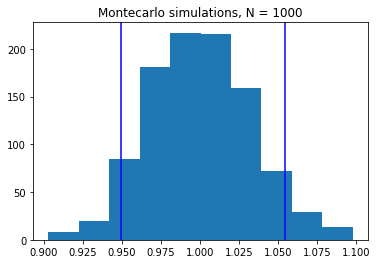

t-test: 
 54.83904997570259

p-value of t-test:
 0.0

2SLS 95% CI: 
 (0.9643297904150419, 1.0359806802314266)

Monte Carlo 95% CI: 
 (0.9492789182227872, 1.0546646645185613)


In [2]:
n = 1000
beta = 1 
pi = 1

monte_carlo_outputs = np.array([utils.do_two_sls(n, beta, pi) for i in range(1000)])
b = monte_carlo_outputs[:,0]
mean_hyp_vals = monte_carlo_outputs[:,1:].mean(0)

monte_carlo_5 = np.percentile(b, 5)
monte_carlo_95 = np.percentile(b, 95)
fig, ax = plt.subplots(1, 1)
ax.hist(b)
ax.set_title(f"Montecarlo simulations, N = {n}")
ax.axvline(x = monte_carlo_5, color = 'b')
ax.axvline(x = monte_carlo_95, color = 'b')
ax.set_title(f"Montecarlo simulations, N = {n}")
plt.show()


print(f"t-test: \n {mean_hyp_vals[0]}\n")
print(f"p-value of t-test:\n {mean_hyp_vals[1]}\n")
print(f"2SLS 95% CI: \n {(mean_hyp_vals[2],mean_hyp_vals[3])}\n")
print(f"Monte Carlo 95% CI: \n {(monte_carlo_5, monte_carlo_95)}")

##### 4.2.c

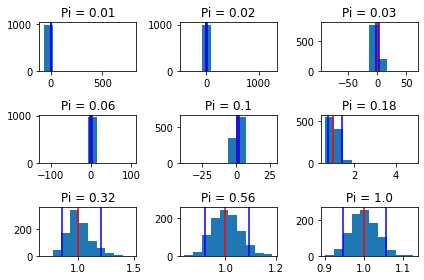

         pi      ttest          pval
0  0.010000  21.621711  1.264276e-02
1  0.017783  23.271105  9.803971e-03
2  0.031623  26.014945  7.092083e-03
3  0.056234  32.466169  3.172944e-03
4  0.100000  42.106698  4.440892e-19
5  0.177828  44.390428  0.000000e+00
6  0.316228  45.655177  0.000000e+00
7  0.562341  48.143835  0.000000e+00
8  1.000000  54.772945  0.000000e+00


In [3]:
n = 1000
pi = np.exp(np.linspace(np.log(0.01),0,9))
fig, ax = plt.subplots(3,3)
ax = ax.reshape(-1)
ttest = np.empty(0)
pval = np.empty(0)
for i, coef in enumerate(pi): 
    monte_carlo_outputs = np.array([utils.do_two_sls(n, beta, coef) for i in range(1000)])
    b = monte_carlo_outputs[:,0]
    mean_hyp_vals = monte_carlo_outputs[:,1:].mean(0)
    
    monte_carlo_5 = np.percentile(b, 5)
    monte_carlo_95 = np.percentile(b, 95)

    # get ttest and pval of single draw for each pi
    x, y, Z = utils.dgp(n, beta, coef)
    model = Two_SLS(y, x, Z)
    ttest = np.append(ttest, mean_hyp_vals[0])
    pval = np.append(pval, mean_hyp_vals[1])

    ax[i].hist(b)
    ax[i].set_title(f"Pi = {np.round(coef, 2)}")
    ax[i].axvline(x=1, color='r', label='True beta')
    ax[i].axvline(x = monte_carlo_5, color = 'b')
    ax[i].axvline(x = monte_carlo_95, color = 'b')
fig.tight_layout()
plt.show()


print(pd.DataFrame({'pi': pi, 'ttest': ttest, 'pval': pval}))

##### 4.3.a

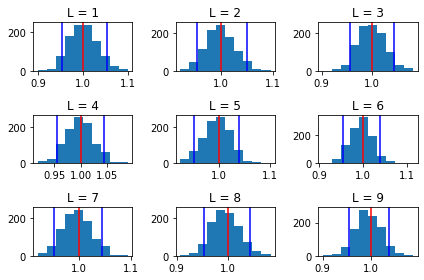

[0.1220946  0.11200768 0.10740916 0.10605082 0.10524293 0.10190362
 0.10805315 0.10880914 0.10537624]
[0.97045746 0.8170313  0.75079573 0.736335   0.73167583 0.68972833
 0.77482462 0.78455455 0.74125494]


In [4]:
### FIGURE 1
n = 1000
beta = 1
N = 9
L = range(1, N+1)

fig, ax = plt.subplots(3, 3)
ax = ax.reshape(-1)
coverage = np.empty(0)
mse      = np.zeros((N,))
for l in L: 
    i = l-1
    pi = np.array([(.5)**(x) for x in range(l)])
    monte_carlo_outputs = np.array([utils.do_two_sls(n, beta, pi) for i in range(1000)])
    b = monte_carlo_outputs[:,0]
    mse[i] = ((b-beta)**2).sum()
    coverage = np.append(coverage, utils.calc_coverage(b))
    monte_carlo_5 = np.percentile(b, 5)
    monte_carlo_95 = np.percentile(b, 95)

    ax[i].hist(b)
    ax[i].set_title(f"L = {l}")
    ax[i].axvline(x=1, color='r', label='True beta')
    ax[i].axvline(x = monte_carlo_5, color = 'b')
    ax[i].axvline(x = monte_carlo_95, color = 'b')
    fig.tight_layout()
plt.show()

print(coverage)
print(mse)

In [5]:
def run_many_instruments_monte_carlo(n_list, beta, N, L, K):
    coverage = np.zeros((N,len(n_list)))
    rmse     = np.zeros((N,len(n_list)))
    mean_se = np.zeros((N,len(n_list)))

    for (ii, n) in enumerate(n_list):
        for l in L:
            i = l-1
            pi = np.array([(.5)**(j) for j in range(l)])
            y_batch, x_batch, Z_batch = utils.mega_dgp(n, K, beta, pi)
            b_se = [utils.dirty_TSLS(y_batch[[k],:].T, x_batch[[k],:].T, Z_batch[k,:,:]) for k in range(K)]
            b_se = np.array(b_se)
            b     = b_se[:,0]
            se    = b_se[:,1]
            rmse[i, ii]       = (((b-beta)**2).mean())**.5
            mean_se[i, ii]    = se.mean()
            coverage[i, ii]   = utils.calc_coverage(b)

    return rmse, mean_se, coverage

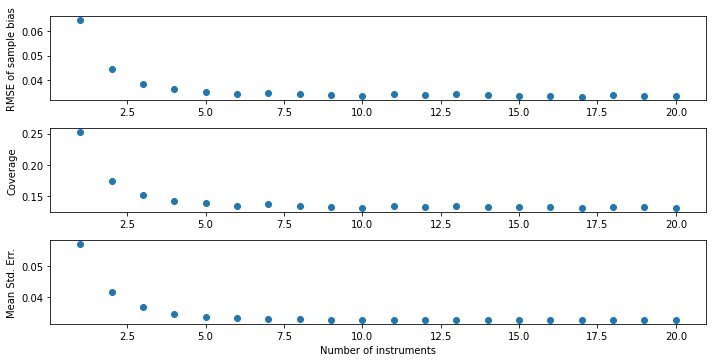

In [6]:
### FIGURE 2
n_list= [50]
beta  = 1
N     = 20
L     = range(1, N+1)
K     = 10000

rmse, mean_se, coverage = run_many_instruments_monte_carlo(n_list, beta, N, L, K)

fig, ax = plt.subplots(3, 1, figsize=(10, 5))

ax[0].scatter(L, rmse[:,0])
ax[1].scatter(L, coverage[:,0])
ax[2].scatter(L, mean_se[:,0])
ax[0].set_ylabel("RMSE of sample bias")
ax[1].set_ylabel("Coverage")
ax[2].set_ylabel("Mean Std. Err.")
ax[2].set_xlabel("Number of instruments")
fig.tight_layout()
plt.show()

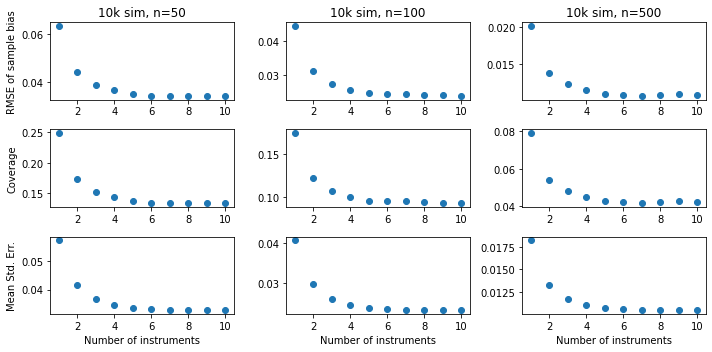

In [7]:
### FIGURE 3
import time
n_list= [50, 100, 500]
beta  = 1
N     = 10
L     = range(1, N+1)
K     = 10000

rmse, mean_se, coverage = run_many_instruments_monte_carlo(n_list, beta, N, L, K)

fig, ax = plt.subplots(3, 3, figsize=(10, 5))
ax = ax.reshape(-1)

ax[0].scatter(L, rmse[:,0])
ax[1].scatter(L, rmse[:,1])
ax[2].scatter(L, rmse[:,2])

ax[3].scatter(L, coverage[:,0])
ax[4].scatter(L, coverage[:,1])
ax[5].scatter(L, coverage[:,2])

ax[6].scatter(L, mean_se[:,0])
ax[7].scatter(L, mean_se[:,1])
ax[8].scatter(L, mean_se[:,2])

ax[0].set_ylabel("RMSE of sample bias")
ax[3].set_ylabel("Coverage")
ax[6].set_ylabel("Mean Std. Err.")

ax[0].set_title("10k sim, n={}".format(n_list[0]))
ax[1].set_title("10k sim, n={}".format(n_list[1]))
ax[2].set_title("10k sim, n={}".format(n_list[2]))

ax[6].set_xlabel("Number of instruments")
ax[7].set_xlabel("Number of instruments")
ax[8].set_xlabel("Number of instruments")
fig.tight_layout()
plt.show()